# 4등팀 event time을 고려한 데이터 추출 -> event time은 크게 중요하지 않은 것 같다고 생각됨

In [1]:
# 파이썬 멀티 프로세싱은 Pool을 임포트하는 방법, process를 임포트하는 방법 2가지가 있다.


from sklearn.model_selection import KFold
import lightgbm

import multiprocessing # 여러 개의 일꾼 (cpu)들에게 작업을 분산시키는 역할
from multiprocessing import Pool # 여러 입력 값 함수의 실행을 병렬 처리, 입력 데이터를 프로세스에 분산시킴(데이터 병렬 처리)
from functools import partial # 함수가 받는 인자들 중 몇개를 고정 시켜서 새롭게 파생된 함수를 형성하는 역할
from data_loader_v2 import data_loader_v2
import os # 운영체제에서 제공하는 기능을 이용할 수 있음
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


train_folder = '../데이콘 스터디/train/'
test_folder = '../데이콘 스터디/test/'
train_label_path = '../데이콘 스터디/train_label.csv'


train_list = os.listdir(train_folder)
test_list = os.listdir(test_folder)
train_label = pd.read_csv(train_label_path, index_col=0)

In [2]:


def data_loader_all_v2(func, files, folder='', train_label=None, event_time=10, nrows=60):   
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)  #imap에 인자(files)가 하나만 들어가야 하므로 고정인자를 넣은 partial함수를 따로 생성
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) # 멀티프로세싱 pool 객체 생성
        df_list = list(pool.imap(func_fixed, files)) # imap은 map이랑 똑같은데 왼쪾에 지정하는 함수가 인자를 1개만 가진 함수여야한다.
        pool.close() # 리소스 낭비를 방지하기위해 close 호출
        pool.join() # 작업 완료를 대기하기 위한 함수 join
     
    combined_df = pd.concat(df_list)
    return combined_df

In [3]:
import time
start_time = time.time()

train= data_loader_all_v2(data_loader_v2, train_list, folder=train_folder, train_label=train_label, event_time=10, nrows=60)
test = data_loader_all_v2(data_loader_v2, test_list, folder=test_folder, train_label=None, event_time=10, nrows=60)

y = train['label']
train.drop('label',axis=1,inplace=True)

print("--- %s, sconds ---" % (time.time()-start_time))

--- 274.6787748336792, sconds ---


## 지현님이 만든 레이블과의 1대1 대응 데이터로 간단한 랜포 모델 적합


In [3]:

## label 별 1개의 파일
# 해당 파일이 대푯값을 가질 수 있을지.. -> 분산분석 필요
sample_list = list(train_label.drop_duplicates().index)
train_list = [f'{i}.csv' for i in sample_list]

# event_time, nrows 변수 조정
# 완전히 상태 B로 변했을 때 산정, event_time = 15
# nrows의 경우 200 안쪽으로 조절해도 괜찮을듯 (test 데이터가 1분이므로)
def data_loader_all_v2(func, files, folder='', train_label=None, event_time=15, nrows=300):
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)     
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(pool.imap(func_fixed, files)) 
        pool.close()
        pool.join()        
    combined_df = pd.concat(df_list)    
    return combined_df

# train_list 반영하여 새로운 train 셋 구성
train = data_loader_all_v2(data_loader_v2, train_list, folder=train_folder, train_label=train_label)

# 의미없는 칼럼 drop
train = train.loc[:, train.nunique() != 1]

X_train = train.drop(['label'], axis=1)
y_train = train['label']
X_train.shape, y_train.shape

((56430, 3367), (56430,))

In [6]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)
# joblib.dump(model, 'model.pkl')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [110]:
test = data_loader_all_v2(data_loader_v2, test_list, folder=test_folder, train_label=None, event_time=20, nrows=60)

In [30]:
pred=model.predict_proba(test)
submission_just3367 = pd.DataFrame(data=pred)
submission_just3367.index = test.index
submission_just3367.index.name = 'id'
submission_just3367 = submission_just3367.sort_index()
submission_just3367 = submission_just3367.groupby('id').mean()
submission_just3367.to_csv('submission_just3367.csv', index=True) #제출 파일 만들기

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


## 스케일링하고 이상치를 제거한 후에 랜포 모델적합 -> 오히려 점수가 떨어짐

## 따라서 이상치에 대한 시각화를 해봄

In [4]:
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
print(robustScaler.fit(train))
train_robustScaled = robustScaler.transform(train)

train_rob=pd.DataFrame(train_robustScaled)

RobustScaler()


## 이상치를 평균에서 3시그마 보다 큰 것으로 정의했을 때, 어떤 컬럼에서 이상치를 어떤 식으로 가지고 있는지를 시각화 시도해봄

## 시각화를 해보니 이상치가 데이터마다 마구잡이로 섞여있는 것이 아니라 어떤 레이블에 n에 속해있는 x 파일이 어떤 컬럼의 이상치를 대부분을 점유하고 있었음

## 가령 V3000 컬럼의 이상치는 여러 레이블에 속하는 파일들이 골고루 가지고 있는 것이 아니라 -> 66번 레이블에 해당하는 450번 파일이 거의 V3000 컬럼의 이상치를 전부 점유하고 있는 형태인 것

## **즉, 이상치도 어떤 파일이 어떤 레이블에 속하는지에 관한 특징이 될 수 있다는 결론이 나옴**

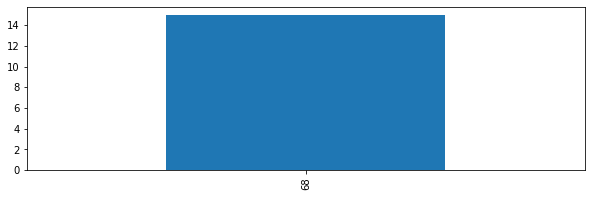

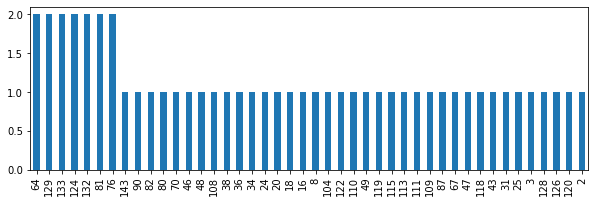

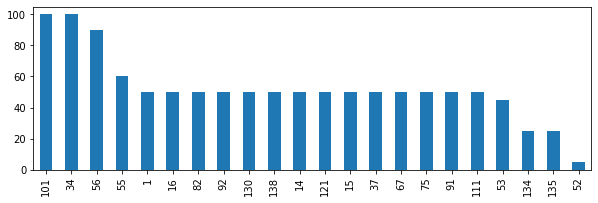

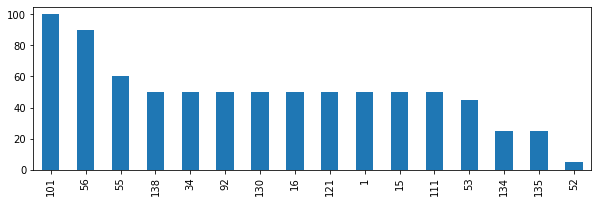

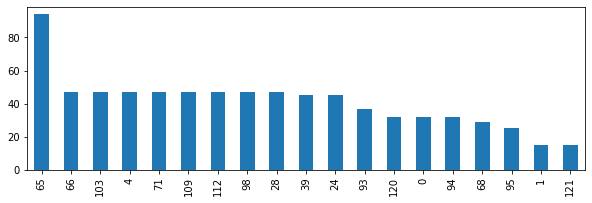

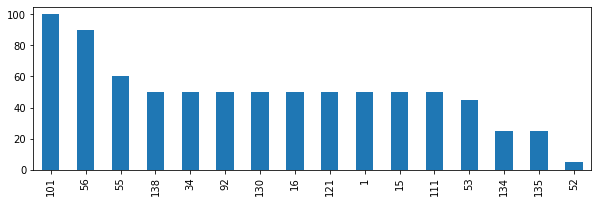

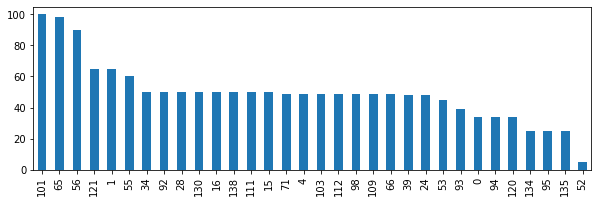

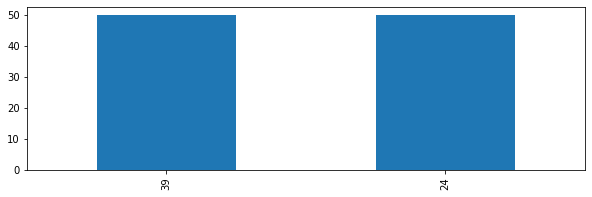

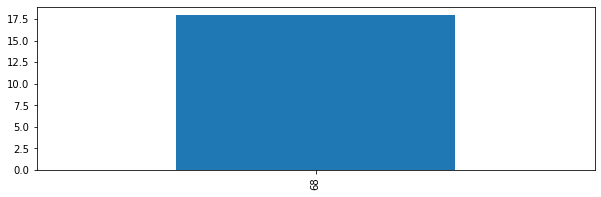

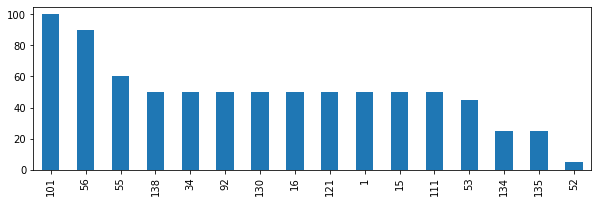

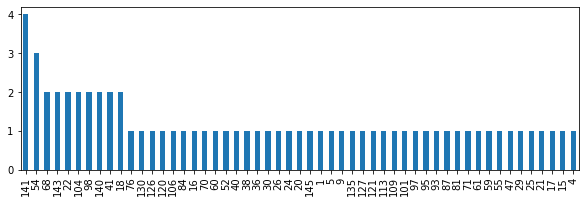

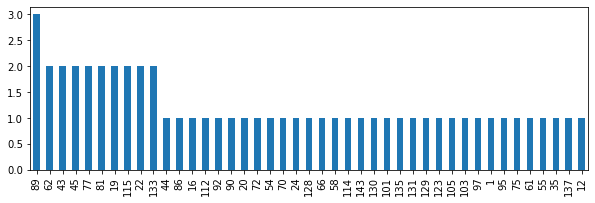

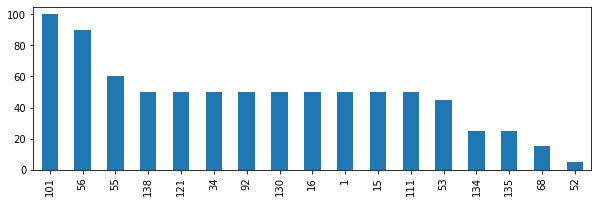

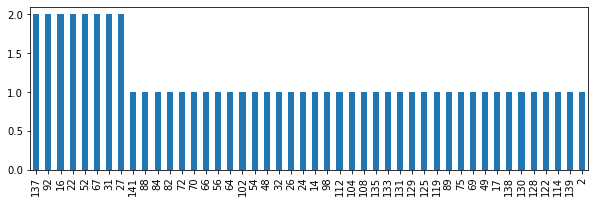

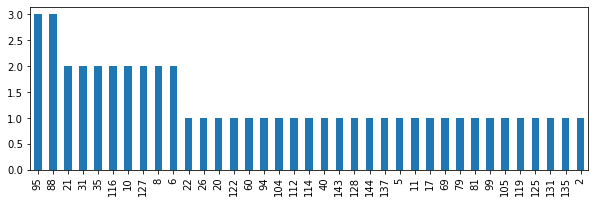

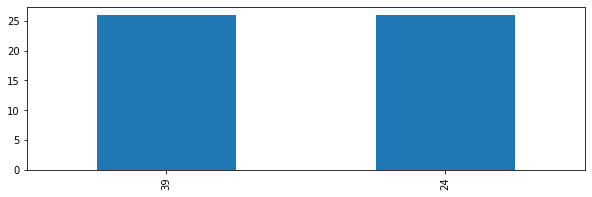

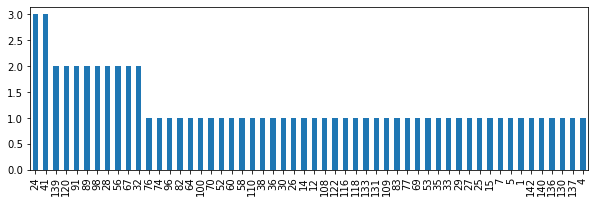

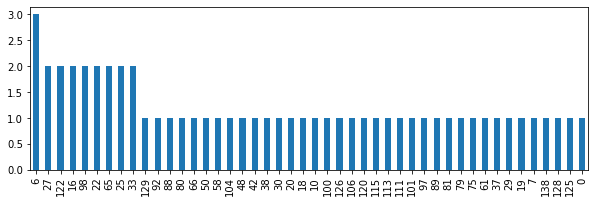

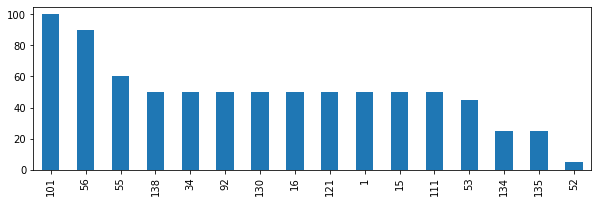

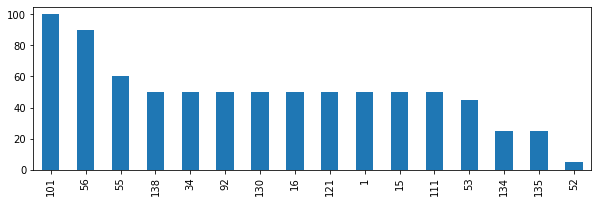

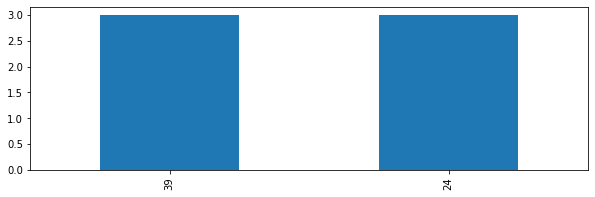

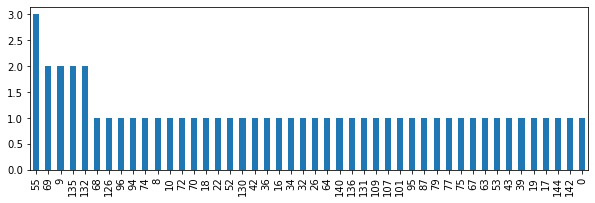

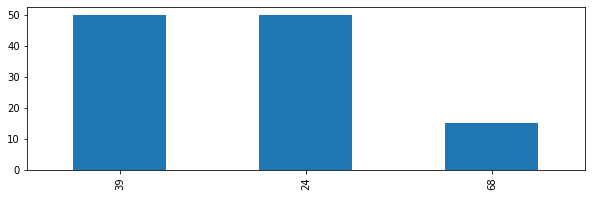

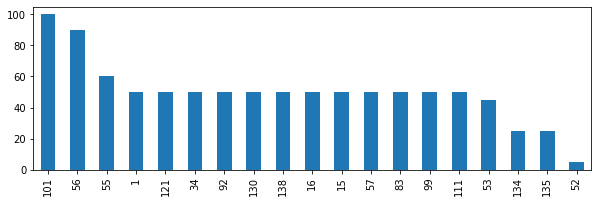

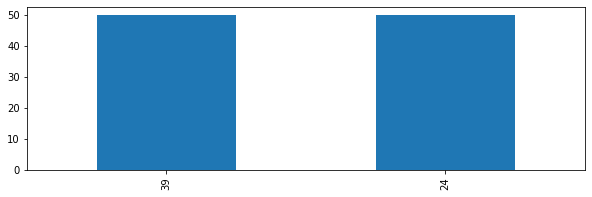

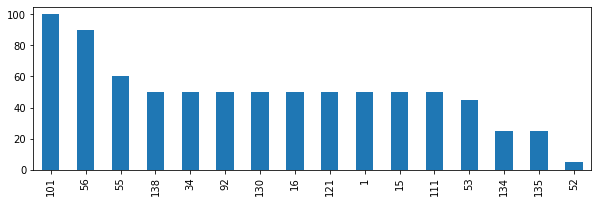

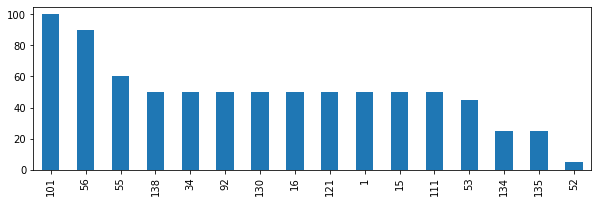

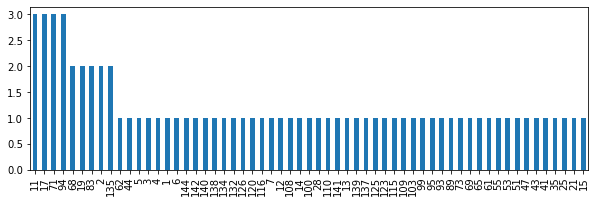

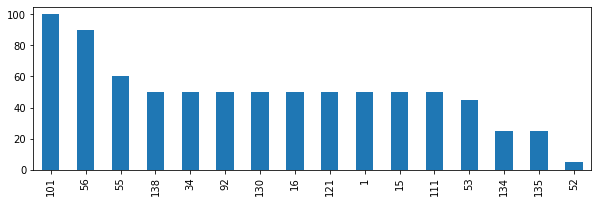

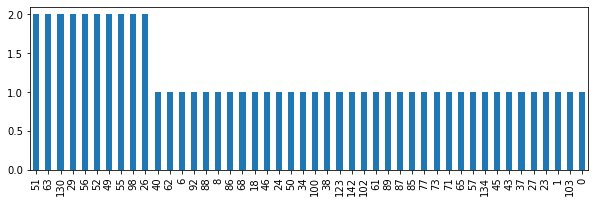

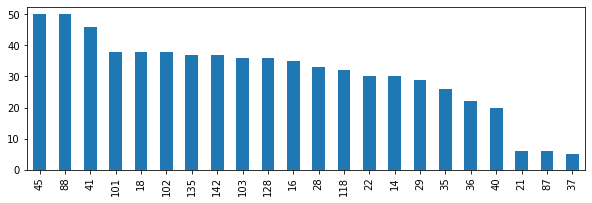

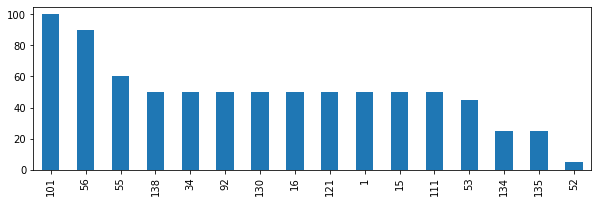

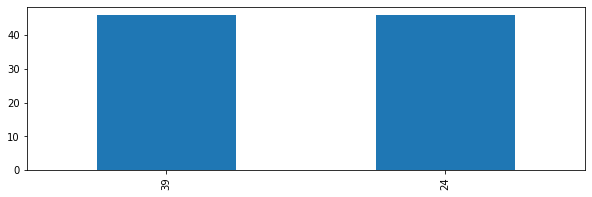

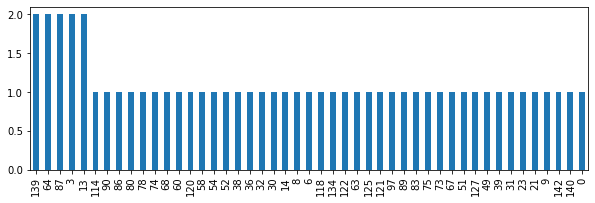

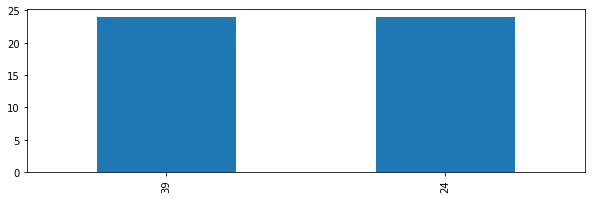

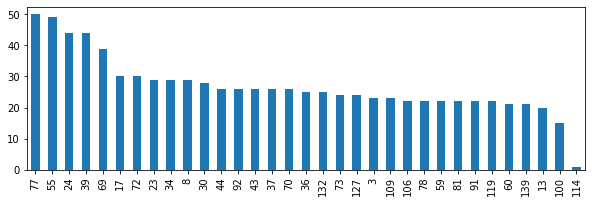

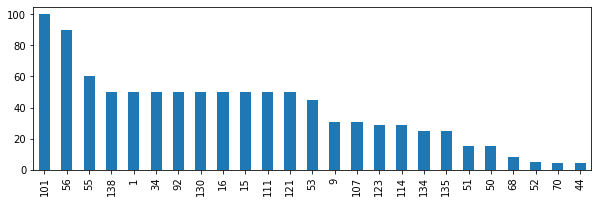

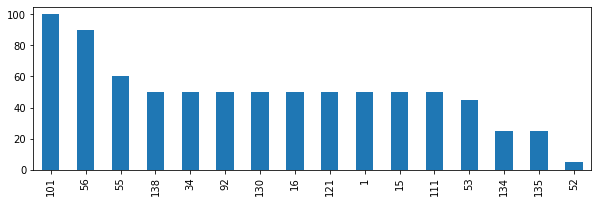

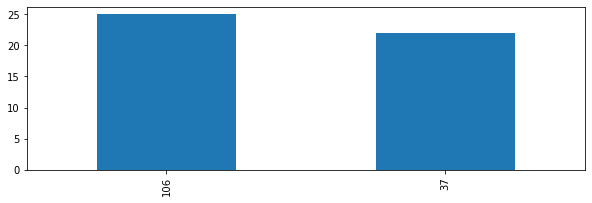

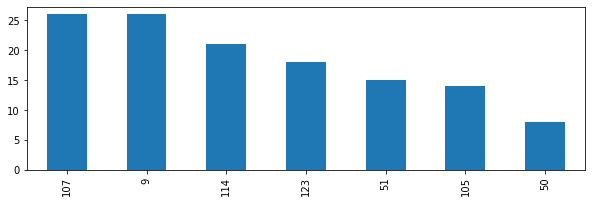

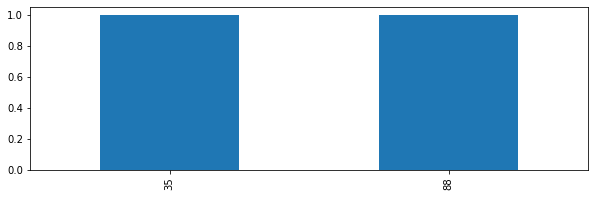

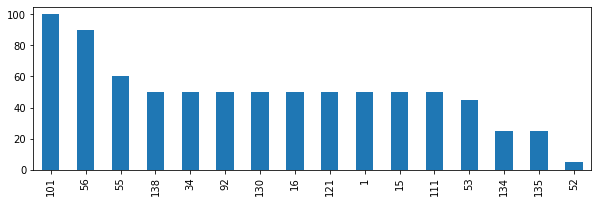

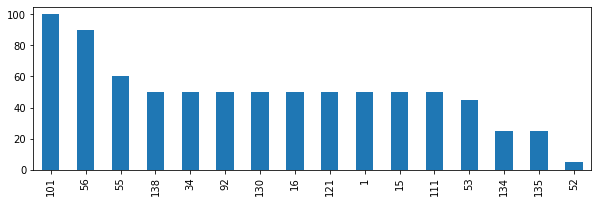

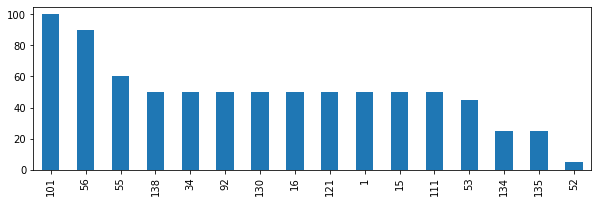

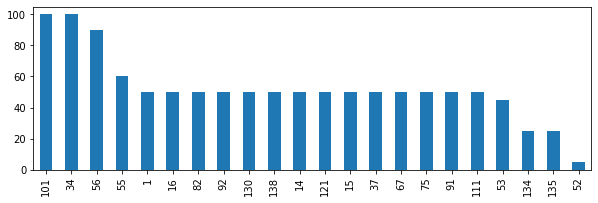

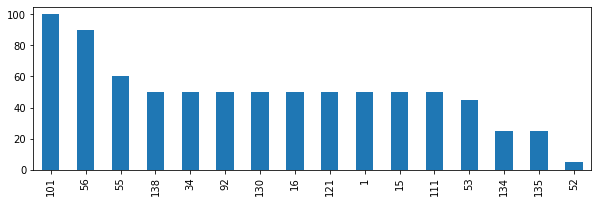

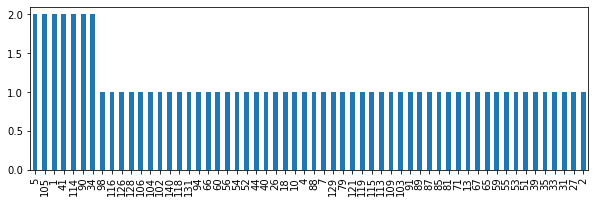

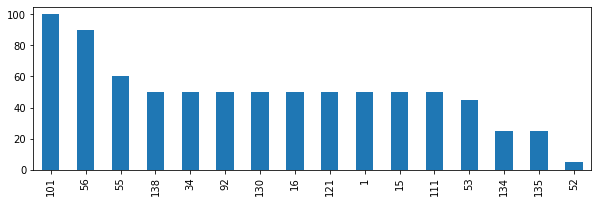

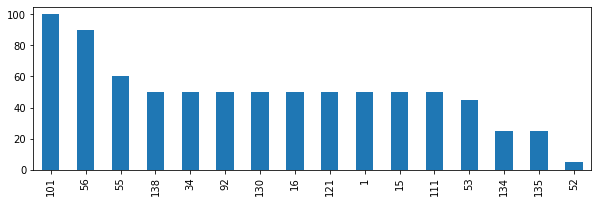

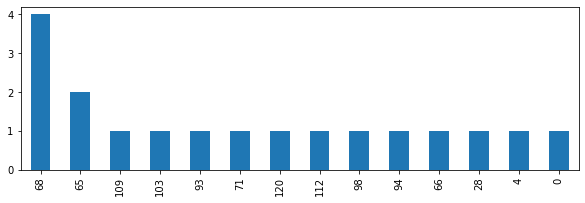

In [10]:
'''이상치를 보유한 컬럼은 약 3600개 중에 2000개가 넘었고, 2000개가 넘는 컬럼을 랜덤으로 뽑아서 이상치를 가지고 있는 파일의 레이블(0~197)로 시각화 했음'''

import warnings
warnings.filterwarnings('ignore')


import math
A=[]
for i in range(0,3368):
   for x in np.where((train_rob.iloc[:,i])>((train_rob.iloc[:,i].mean())+3*train_rob.iloc[:,i].std())):
       A.append(x/285)   # 285로 나누면 그게 바로 해당 파일이 속하는 레이블임

import math
A=pd.DataFrame(A)
A=A.T
A=A.fillna(-1).astype(int)

A2 = A.loc[:, A.nunique() != 1]

import random

for i in random.sample(list(A2.columns),50):
    ax = plt.subplots(1,1,figsize=(10,3))
    A[i].value_counts().drop(-1).plot.bar()

# 시각화 결과는 만약 2 번째의 그래프처럼 소수의 이상치가 골고루 퍼져 있다면 이상치가 레이블을 결정하는 데에 큰 도움이 되지는 않겠지만, 대부분 다른 그래프를 보면 알 수 있듯이 이상치가 레이블에 속하는 데에 특징이 될 수 있다는 결론을 내릴 수 있음.

## 따라서 레이블의 불균형에 대한 문제점은 데이터의 전처리보다는 그저 상태 B부분에 대한 데이터를 K-fold로 많이 학습시키는 방법이 가장 좋은 것 같다. 